<h1><center>CSEN1022:Assignment 3</center></h1>
<h3><center>Winter 2022</center></h3>
<hr style="border:2px solid black"> </hr>

## <u> Please don't forget to fill in this data </u>
**Member 1**

Name: 

GUC-ID: 

Elective Tutorial No.: T-

**Member 2**

Name: 

GUC-ID: 

Elective Tutorial No.: T-

<hr style="border:2px solid black"> </hr>

## Imports (Don't Edit)

In [1]:
# ONLY USE THESE IMPORTS.
# PLEASE DON'T EDIT THIS CELL.
# You can use any library to import your data.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read Data

In [2]:
import cv2
import os

In [3]:
from PIL import Image
from numpy import asarray

In [4]:
airplane_train_path = "Dataset/train/airplane"
bird_train_path = "Dataset/train/bird"
truck_train_path = "Dataset/train/truck"

airplane_test_path = "Dataset/test/airplane"
bird_test_path = "Dataset/test/bird"
truck_test_path = "Dataset/test/truck"

In [5]:
def load_images_from_folder(folder):
    images_arr = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images_arr.append(asarray(img))
    return images_arr

In [6]:
airplane_train = load_images_from_folder(airplane_train_path)
bird_train = load_images_from_folder(bird_train_path)
truck_train = load_images_from_folder(truck_train_path)

airplane_test = load_images_from_folder(airplane_test_path)
bird_test = load_images_from_folder(bird_test_path)
truck_test = load_images_from_folder(truck_test_path)


In [7]:
train = [] 
train = airplane_train + bird_train + truck_train

In [8]:
test = [] 
test = airplane_test + bird_test + truck_test

In [9]:
np.shape(np.array(train))

(15000, 32, 32, 3)

<hr style="border:2px solid black"> </hr>

# Perform K means clustering for all 3 classes (Training Data).
### Return (memberships, centroids, dbi) --> (vector, matrix, scalar value).

In [10]:
def flatten_matrix(matrix):
    matrix_int64 = np.int64(matrix)
    return matrix.flatten()

In [11]:
def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() ) #different object reference each time
    return list_of_objects

In [12]:
import random
def intialize_random_centroid(img_size):
    centroid = np.random.randint(low=0, high=255, size = img_size)
    centroid = np.int64(centroid)
    return centroid

In [13]:
def intialize_random_centroids(img_size, k):
    centroids = []
    for i in range(k):
        centroid = intialize_random_centroid(img_size)
        centroids.append(centroid)
    return centroids

In [14]:
def calculate_euclidean_distance(matrix1, matrix2):
    return np.linalg.norm(matrix1 - matrix2)

In [15]:
def calculate_membership(image, centroids):
    distances = []
    for i in range(len(centroids)):
        euclidean_distance = calculate_euclidean_distance(image, centroids[i])
        distances.append(euclidean_distance)
    
    min_index = np.argmin(distances)
    return min_index

In [16]:
def cluster_dataset(dataset, memberships,k):
    clusterd_dataset = init_list_of_objects(k) 
    for i in range(len(dataset)):
        index = memberships[i]
        clusterd_dataset[index].append(dataset[i])
    return clusterd_dataset

In [17]:
def perform_k_means_one_iteration(dataset, centroids, k):
    memberships = []
    for i in range(len(dataset)):
        image = dataset[i]
        membership = calculate_membership(image, centroids)
        memberships.append(membership)
    return memberships

In [18]:
def calculate_centroids(dataset, memberships,k):
    clustered_dataset = cluster_dataset(dataset, memberships,k)
    centroids = []
    for i in range(k):
        new_centroid = np.mean(clustered_dataset[i], axis=0)
        centroids.insert(len(centroids),new_centroid)
    return centroids

In [19]:
def calculate_dbi(centroids):
    k = len(centroids)
    dbi = []
    for i in range(k - 1):
        for j in range(i, k - 1):
            distance = calculate_euclidean_distance(centroids[i], centroids[j])
            dbi.append(distance)
    return np.mean(dbi)

In [20]:
def perform_k_means(dataset, k):
    dataset_shape = np.shape(dataset[0])
    centroids = intialize_random_centroids(dataset_shape, k)
    old_memberships = []
    new_memberships = perform_k_means_one_iteration(dataset, centroids, k)
    i=0
    while old_memberships != new_memberships:
        old_memberships = new_memberships.copy()
        centroids = calculate_centroids(dataset, new_memberships,k)
        new_memberships = perform_k_means_one_iteration(dataset, centroids, k)
        i += 1
    
    dbi = calculate_dbi(centroids)
    return new_memberships, centroids, dbi

In [21]:
memberships, centroids, dbi = perform_k_means(train, 3)

<hr style="border:2px solid black"> </hr>

# Repeat the previous process 10 times. 
### Pick the membership vector and the centroids matrix corresponding to the best dbi.
##### Make sure you return max_counts and confusion_matrix.
(keep history in whatever datastructure you like).

In [22]:
def perform_k_means_n_times(dataset, k, n):
    memberships_list = []
    centroids_list = []
    dbi_list = []
    for i in range(n):
        memberships, centroids, dbi = perform_k_means(dataset, k)
        memberships_list.append(memberships)
        centroids_list.append(centroids)
        dbi_list.append(dbi)
    min_index = np.argmin(dbi_list)
    return memberships_list[min_index], centroids_list[min_index], dbi_list[min_index]

In [23]:
best_membership_matrix, best_centroids, best_dbi = perform_k_means_n_times(train, 3, 10)

In [24]:
def organize_confusion_matrix(confusion_matrix):
    k = len(confusion_matrix)
    organized_confusion_matrix = np.zeros(np.shape(confusion_matrix))
    max_indices = np.argmax(confusion_matrix, axis=0)
    organized_confusion_matrix = confusion_matrix[max_indices]
    return organized_confusion_matrix

In [25]:
def memberships_to_confusion_matrix(memberships, k):
    confusion_matrix = np.zeros((k, k))
    images_per_class = len(memberships)//k
    for i in range(k):
        for j in range(images_per_class*i,images_per_class*(i+1)):
            index = memberships[j]
            confusion_matrix[i][index] = confusion_matrix[i][index] + 1
    return confusion_matrix

In [26]:
def test_k_means(testset, best_centroids):
    k = len(best_centroids)
    memberships = perform_k_means_one_iteration(testset, best_centroids, k)
    confusion_matrix = memberships_to_confusion_matrix(memberships, k)
    max_counts = np.amax(confusion_matrix, axis=1)
    organized_confusion_matrix = organize_confusion_matrix(confusion_matrix)
    return organized_confusion_matrix, max_counts

In [27]:
confusion_matrix, max_counts = test_k_means(test, best_centroids)

<hr style="border:2px solid black"> </hr>

## Don't Edit the Following Cells, Just Run & Save them.

Text(0.5, 1.0, 'Best Counts')

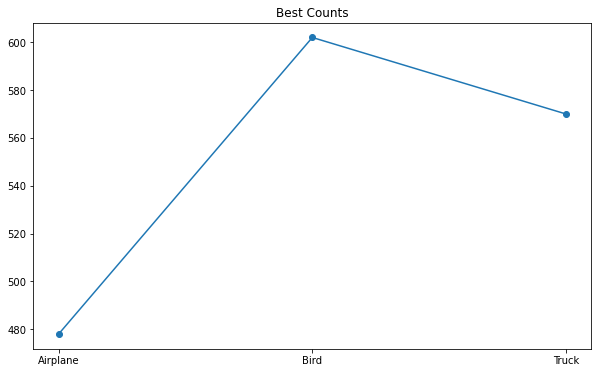

In [28]:
plt.figure(figsize=(10,6))
plt.plot(['Airplane','Bird','Truck'],max_counts,'-o')
plt.title('Best Counts')

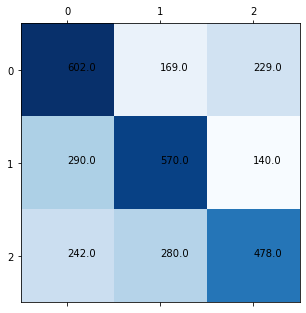

In [29]:
plt.rc('figure', figsize=[5,5])
plt.matshow(confusion_matrix,cmap="Blues")
for i in range(0,confusion_matrix.shape[0]):
    for j in range(0,confusion_matrix.shape[1]):
        plt.annotate(confusion_matrix[i,j],(j,i))